# Pseudotime analyis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Intestinal_epithelial_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 118336 × 1807
    obs: 'sort_batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'batch', 'publication', 'sample_name', 'tissue', 'derive', 'detail_tissue', 'time', 'time2', 'main_cells', 'protocol', 'tech', 'tech_detail', 'molecular', 'gel', 'leiden', 'day'
    uns: 'leiden', 'level_1_colors', 'level_2_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scPoli', 'X_umap', 'X_umap_initial', 'X_umap_min', 'X_umap_sc'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# Pseudotime analysis

In [3]:
sc.tl.diffmap(adata)

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


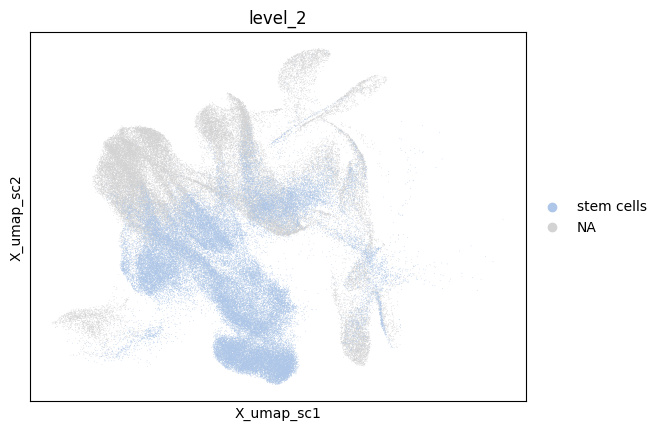

In [4]:
sc.pl.embedding(adata, basis='X_umap_sc', color='level_2', groups=['stem cells'])

In [5]:
# let's pick some random stem cells

In [11]:
n=10
inds=np.random.choice(list(adata.obs[adata.obs['level_2']=='stem cells'].index), n, replace=False)

In [16]:
ii=np.where([a in inds for a in adata.obs.index])[0]

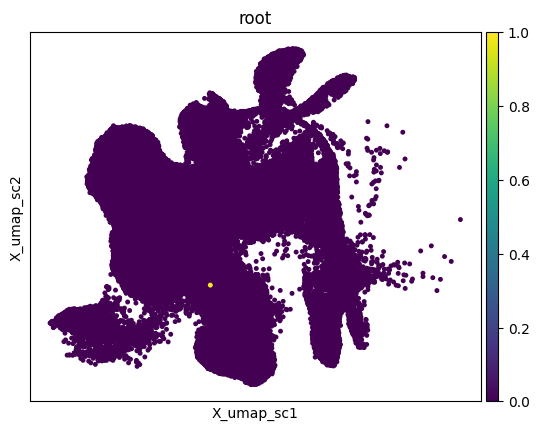

In [17]:
# Let's pick a root cell
i=ii[0]
z=np.zeros(len(adata))
z[i]=1
adata.obs['root']=z
sc.pl.embedding(adata, basis='X_umap_sc', color='root', s=50)
adata.uns['iroot'] = i
sc.tl.dpt(adata)

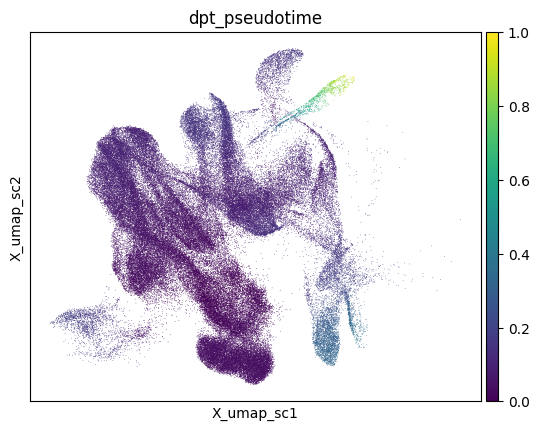

In [18]:
sc.pl.embedding(adata, basis='X_umap_sc', color='dpt_pseudotime', color_map='viridis')

# Cellrank analysis

In [19]:
pk = cr.kernels.PseudotimeKernel(adata, time_key='dpt_pseudotime')

In [20]:
# Doesnt work for some root states, since matrix isn't row stochastic (it's because neighbor graph is corrupted,
# because of subsampling and not recomputing neighbor graph)
pk.compute_transition_matrix()

  0%|          | 0/118336 [00:00<?, ?cell/s]

PseudotimeKernel[n=118336, dnorm=False, scheme='hard', frac_to_keep=0.3]

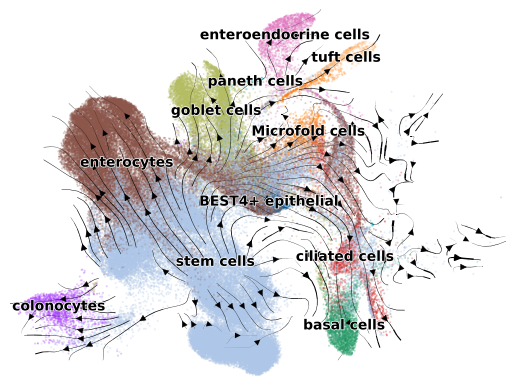

In [22]:
pk.plot_projection(basis='X_umap_sc', color="level_2", recompute=True, 
                   connectivities=adata.obsp['connectivities'], title='')

In [23]:
T=pk.transition_matrix

In [25]:
import pickle
with open(f'{Path}/dpt.pkl', 'wb') as handle:
    pickle.dump(T, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
pseudotime=adata.obs[['dpt_pseudotime']]

In [28]:
pseudotime.to_pickle(f'{Path}/dpt_epithelial.pkl')